In [1]:
import praw
import prawcore
from time import sleep
from tqdm.notebook import tqdm
import json
import pandas as pd
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
# !pip install langdetect
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from itertools import chain
import seaborn as sns
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import string
from tabulate import tabulate


# Suppress specific warning categories
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-v0_8")

# Setting aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [4]:
with open("..\Data\combined.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [5]:
df = pd.DataFrame(data)

In [6]:
# Count posts and comments
num_posts = df[df['type'] == 'submission'].shape[0]
num_comments = df[df['type'] == 'comment'].shape[0]

In [7]:
print(f"Total posts: {num_posts}")
print(f"Total comments: {num_comments}")

Total posts: 1945
Total comments: 37981


In [8]:
df.head(5)

,id,type,subreddit,title,selftext,created_utc,created,author,score,upvote_ratio,num_comments,url,permalink,parent_id,link_id,body
0,1kp083c,submission,RussiaUkraineWar2022,I want to ask EVERY Russian,"Greetings to all, especially Russian citizens....",1.747508e+09,2025-05-17T18:48:47,DANDYXIK_111,828,0.94,174.0,https://i.redd.it/nrbhbr6o1e1f1.jpeg,https://reddit.com/r/RussiaUkraineWar2022/comm...,NaN,NaN,NaN
1,msugd1y,comment,RussiaUkraineWar2022,NaN,NaN,1.747512e+09,2025-05-17T20:05:24,CDI-1,957,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,I am Russian. Thank you for your respectful at...
2,msufdd7,comment,RussiaUkraineWar2022,NaN,NaN,1.747512e+09,2025-05-17T19:59:58,outsider4200,268,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,The EU needs to start blocking Russian propaga...
3,msufpk1,comment,RussiaUkraineWar2022,NaN,NaN,1.747512e+09,2025-05-17T20:01:50,loadnurmom,82,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,I got brigaded in another sub\n\nHere are a fe...
4,msubcn4,comment,RussiaUkraineWar2022,NaN,NaN,1.747511e+09,2025-05-17T19:37:48,None,32,NaN,NaN,NaN,https://reddit.com/r/RussiaUkraineWar2022/comm...,t3_1kp083c,t3_1kp083c,[removed]


In [9]:
# Merge 'title' + 'selftext' for submissions and use 'body' for comments
df['text'] = df.apply(
    lambda row: (row.get('title', '') + ' ' + row.get('selftext', '')) if row['type'] == 'submission' else row.get('body', ''),
    axis=1
)

In [10]:
#  Drop rows with null/removed/deleted content
df = df[df['text'].notnull()]
df = df[~df['text'].isin(['[removed]', '[deleted]'])]
df = df[~df['text'].str.contains("i am a bot", case=False, na=False)]

In [11]:
# Basic cleaning & abbreviation setup
abbreviations = {
    "lol": "laugh out loud", "omg": "oh my god", "idk": "i don't know",
    "rn": "right now", "u": "you", "ur": "your", "btw": "by the way",
    "brb": "be right back", "thx": "thanks", "pls": "please", "imo": "in my opinion",
    "fwiw": "for what it's worth", "lmao": "laughing my ass off"
}

In [12]:
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))


In [13]:
#  Clean + tokenize + stem function
def preprocess(text):
    if not text or not isinstance(text, str):
        return []

    # Lowercase, remove zero-width spaces
    text = text.replace('\u200b', '').lower()

    # Expand abbreviations
    for abbr, full in abbreviations.items():
        text = re.sub(rf'\b{abbr}\b', full, text)

    # Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove non-ASCII characters (emojis, special symbols)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Remove stopwords and short tokens
    tokens = [t for t in tokens if len(t) > 1 and t not in stop_words]

    
    # Stemming
    stemmed_tokens = [stemmer.stem(t) for t in tokens if t.isalpha()]
    return stemmed_tokens

    


In [14]:
# Apply full preprocessing
df['tokens'] = df['text'].progress_apply(preprocess)


  0%|          | 0/37118 [00:00<?, ?it/s]

In [15]:
# Flatten for frequency count
all_tokens = [t for sublist in df['tokens'] for t in sublist]
token_counts = Counter(all_tokens)

In [16]:
# Filter: remove rare (1x) words
df['tokens_filtered'] = df['tokens'].apply(lambda toks: [t for t in toks if token_counts[t] > 1])

# Identify top 20 most frequent terms
top_20 = set([t for t, _ in token_counts.most_common(20)])

# Remove top 20 high-frequency terms
df['final_tokens'] = df['tokens_filtered'].apply(lambda toks: [t for t in toks if t not in top_20])

# Join for vectorizers
df['cleaned_string'] = df['final_tokens'].apply(lambda x: ' '.join(x))

In [17]:
# Preview
print("Sample cleaned data:")
print(df[['type', 'subreddit', 'cleaned_string']].head())

Sample cleaned data:
         type             subreddit  \
0  submission  RussiaUkraineWar2022   
1     comment  RussiaUkraineWar2022   
2     comment  RussiaUkraineWar2022   
3     comment  RussiaUkraineWar2022   
5     comment  RussiaUkraineWar2022   

                                      cleaned_string  
0  ask everi greet especi citizen hope best czech...  
1  thank respect attitud although part support de...  
2  eu need start block propaganda hand censor con...  
3  got brigad anoth sub answer probabl disinform ...  
5  situat aw almost inform present mostli avoid i...  


In [18]:
df.to_csv("reddit_russiaukraine_cleaned.csv", index=False)
print("Preprocessed data saved to reddit_russiaukraine_cleaned.csv")

Preprocessed data saved to reddit_russiaukraine_cleaned.csv


In [19]:
df.columns

Index(['id', 'type', 'subreddit', 'title', 'selftext', 'created_utc',
       'created', 'author', 'score', 'upvote_ratio', 'num_comments', 'url',
       'permalink', 'parent_id', 'link_id', 'body', 'text', 'tokens',
       'tokens_filtered', 'final_tokens', 'cleaned_string'],
      dtype='object')

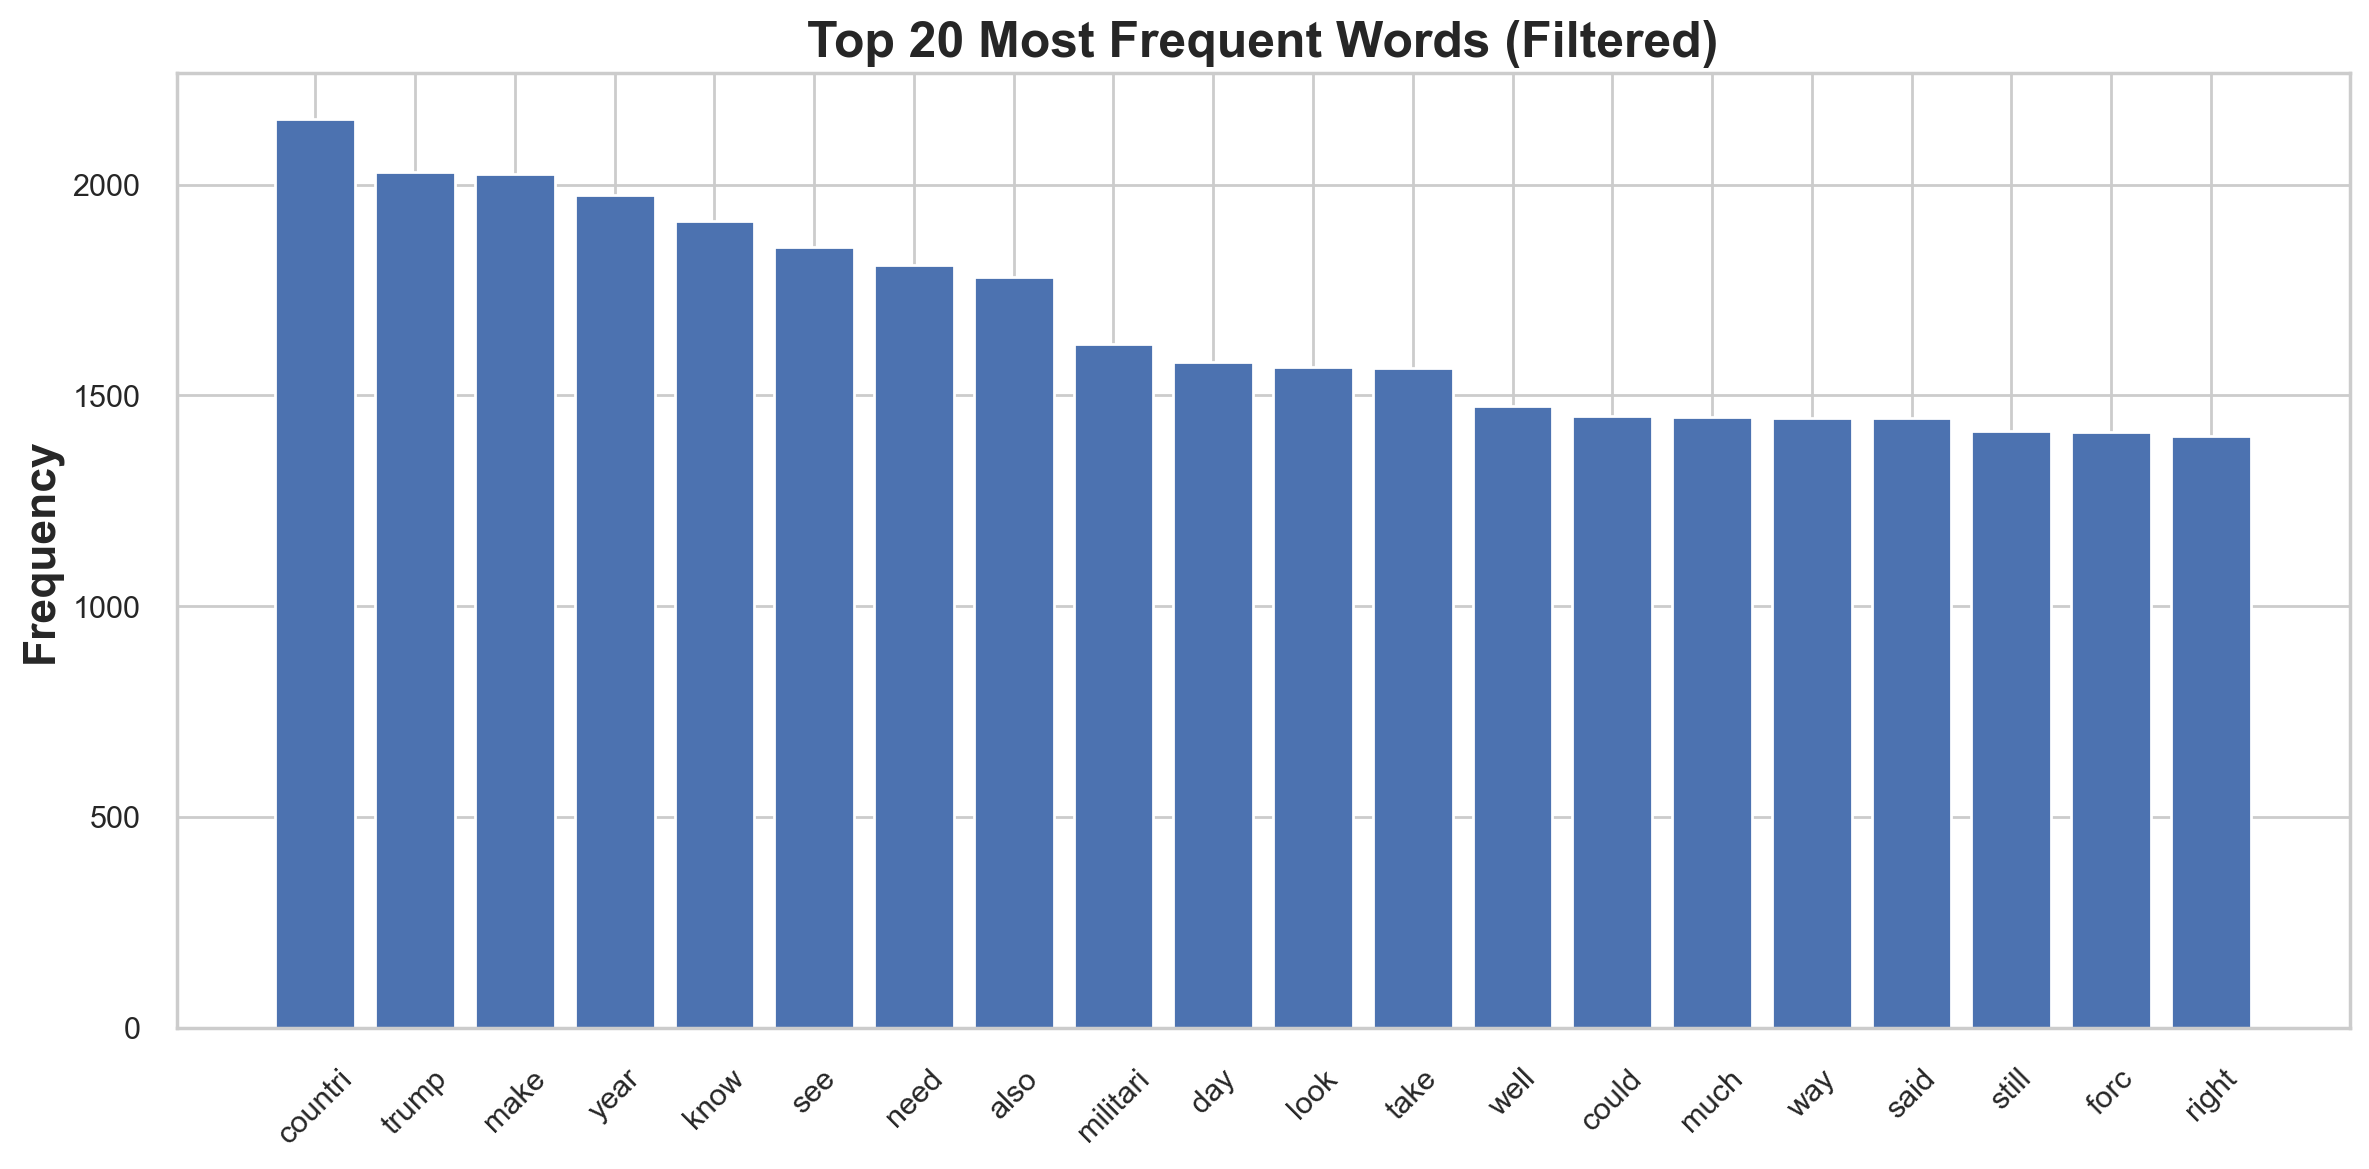

In [20]:
# Flatten all tokens
all_tokens = [token for sublist in df["final_tokens"] for token in sublist]
token_counts = Counter(all_tokens)
top_words = token_counts.most_common(20)

# Plot
words, counts = zip(*top_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words (Filtered)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

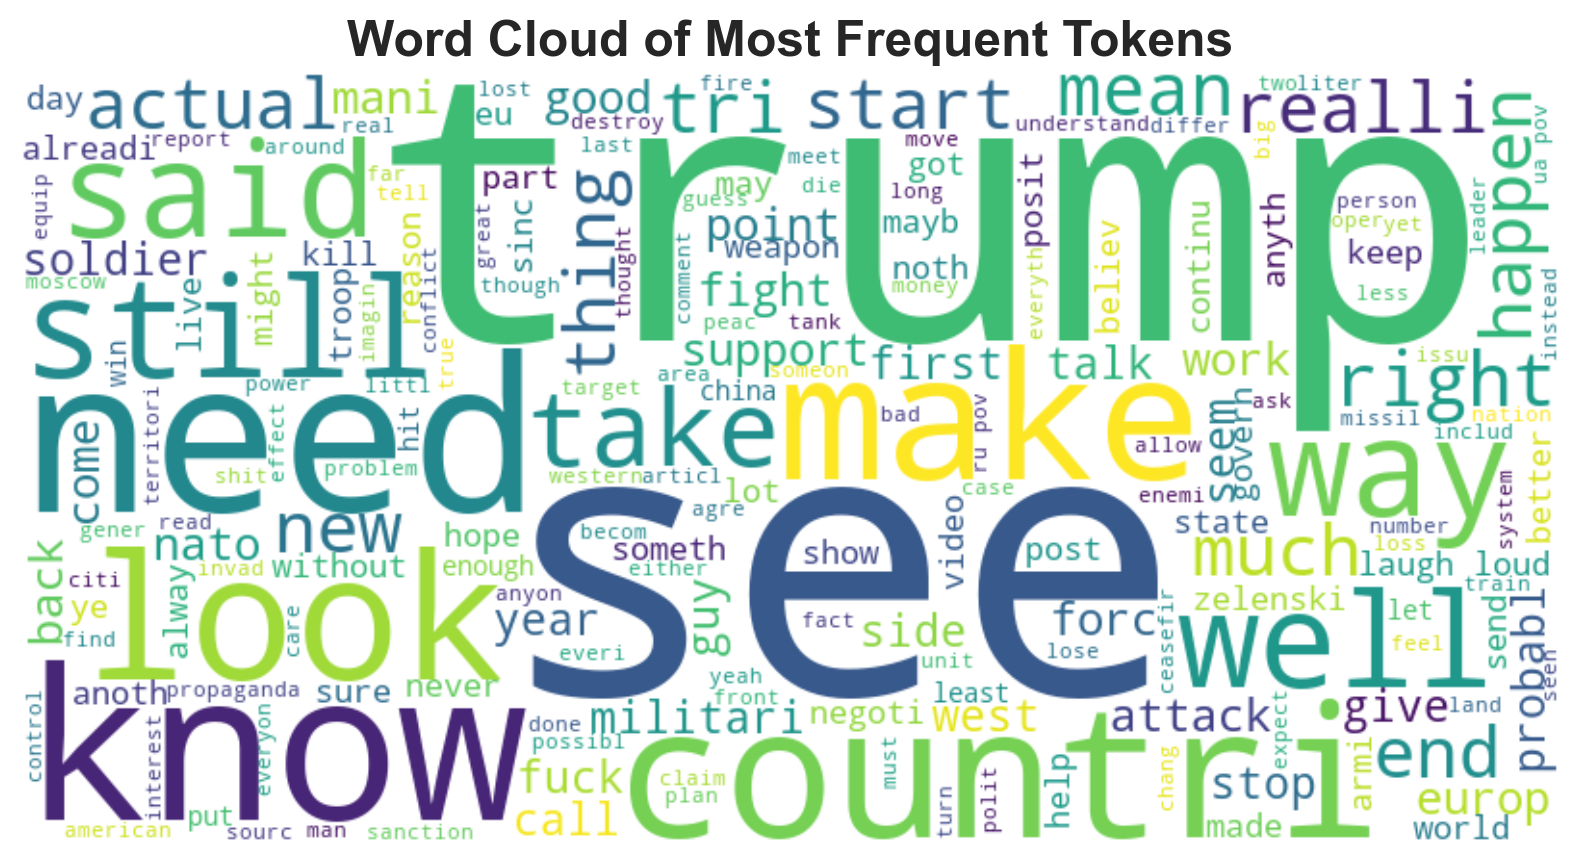

In [21]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Tokens")
plt.show()

In [26]:
nltk.download("vader_lexicon")

# Initialize VADER
sia = SentimentIntensityAnalyzer()
analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
# Apply VADER sentiment analysis
df["vader_scores"] = df["cleaned_string"].astype(str).apply(analyzer.polarity_scores)
df["compound"] = df["vader_scores"].apply(lambda x: x["compound"])

# Custom sentiment classification
def classify_custom_vader(score):
    if score >= 0.01:
        return "positive"
    elif score <= -0.01:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["compound"].apply(classify_custom_vader)

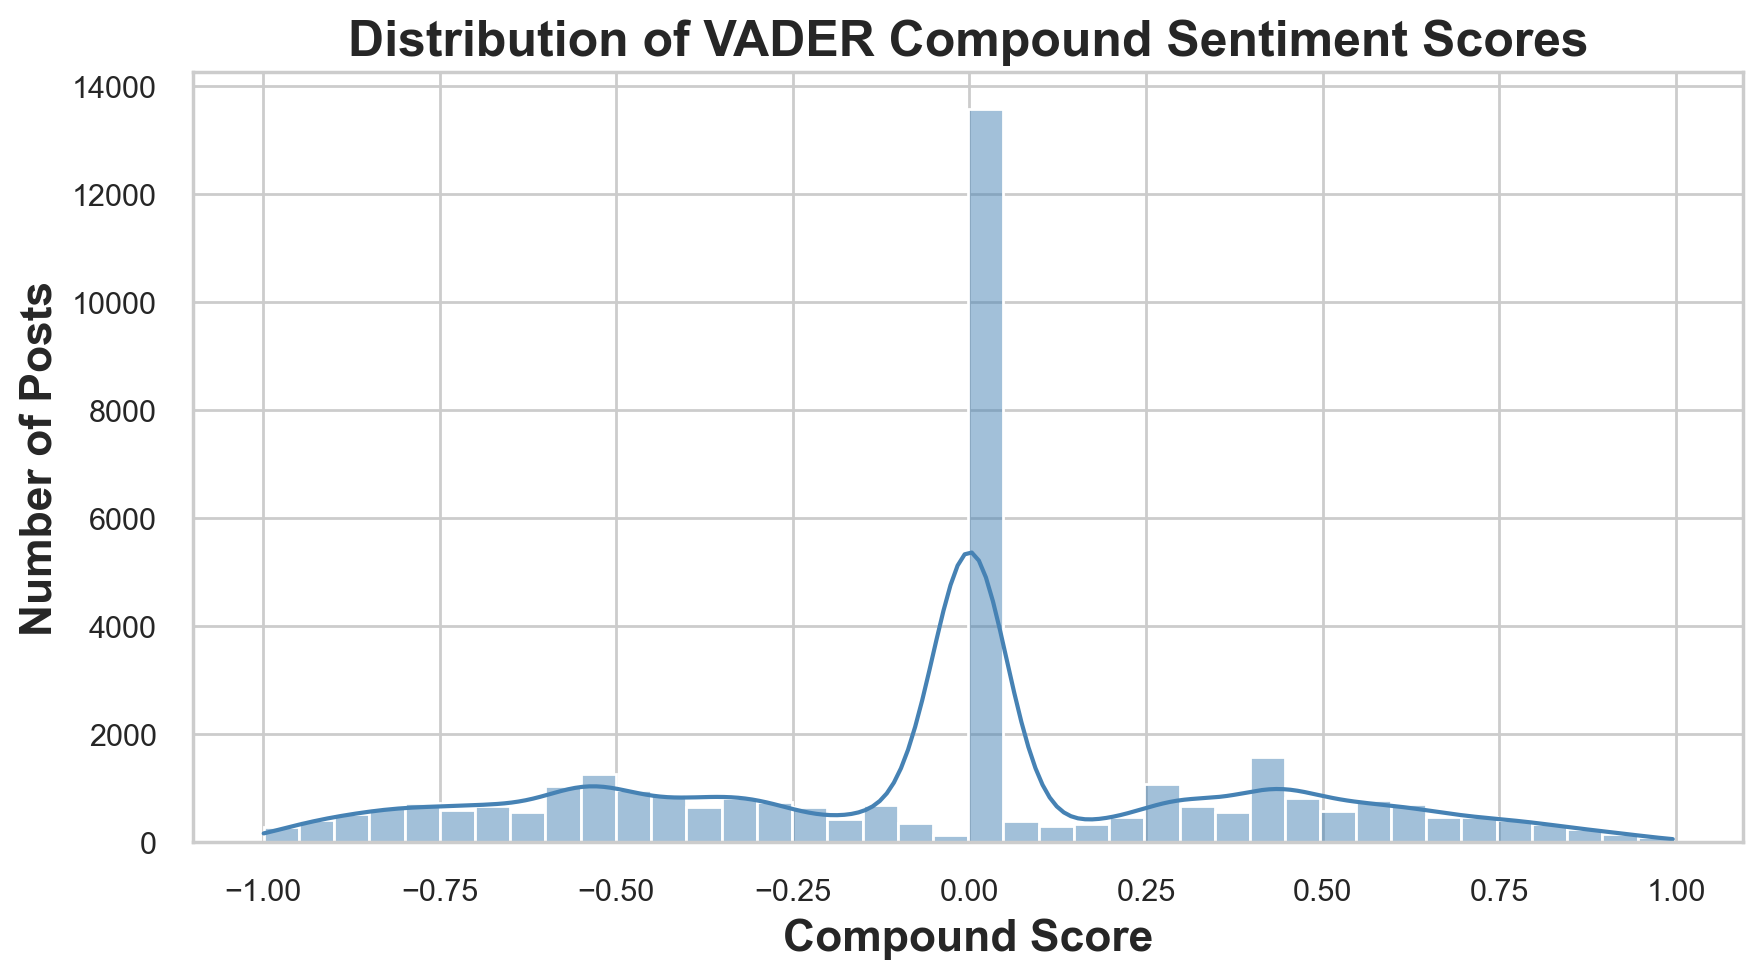

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(df["compound"], bins=40, kde=True, color="steelblue")
plt.title("Distribution of VADER Compound Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.show()

In [37]:
df.groupby("sentiment")["compound"].mean().sort_values(ascending=False)

sentiment
positive    4.540388e-01
neutral    -6.333409e-07
negative   -5.062962e-01
Name: compound, dtype: float64

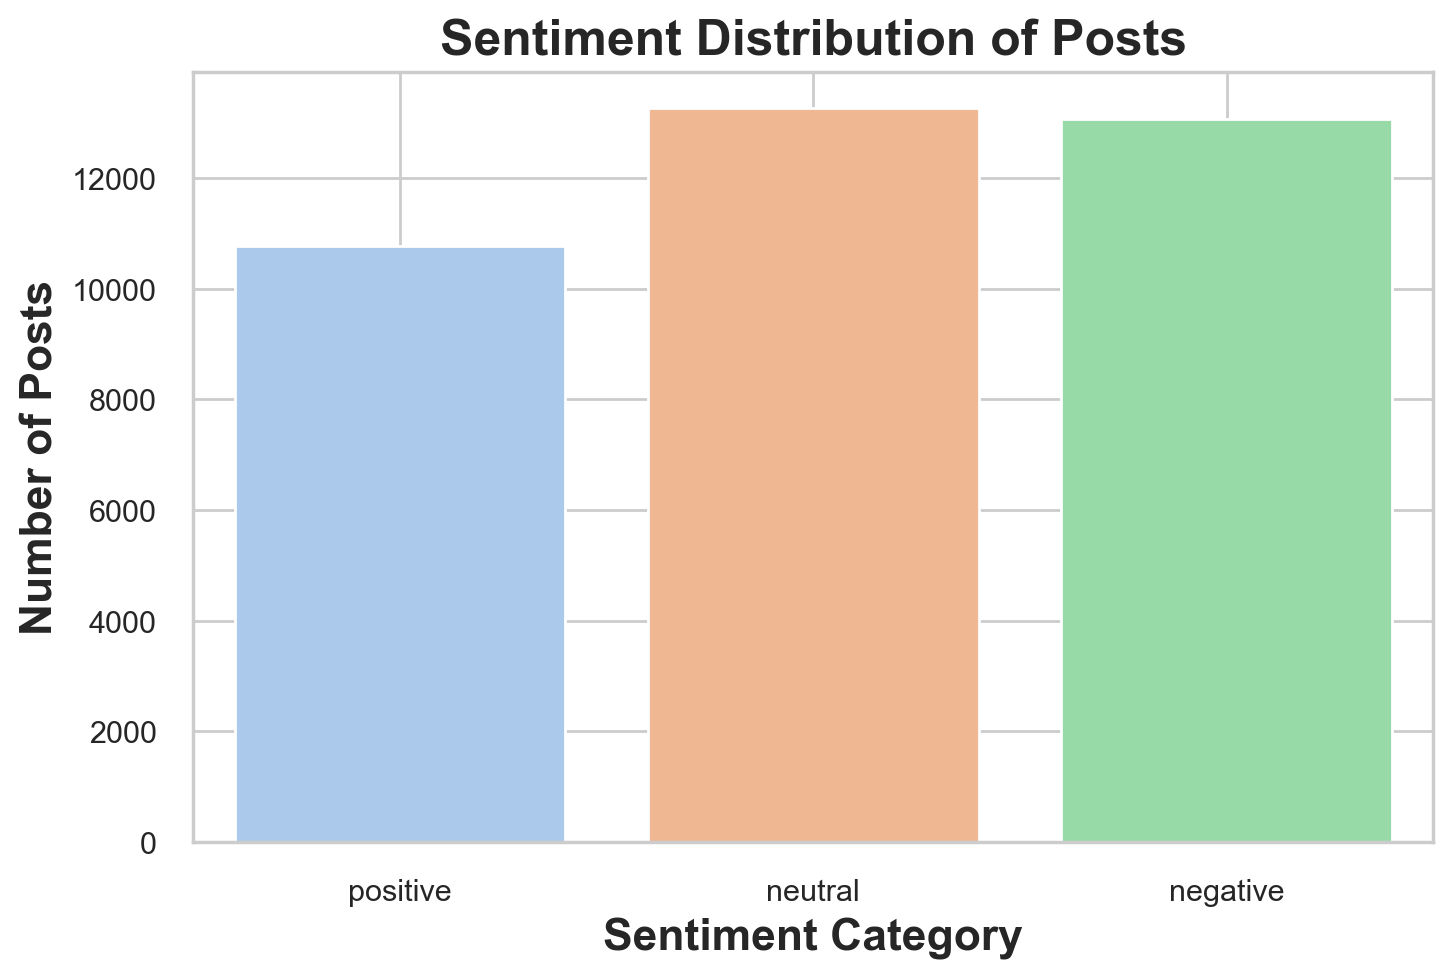

In [38]:


plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment", palette="pastel", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution of Posts")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Posts")
plt.grid(True)
plt.show()


In [54]:
# Vectorizer parameters
vectorizer_params = {
    'max_df': 0.9,
    'min_df': 5,
    'stop_words': 'english',
    'max_features': 1000
}

lda_params = {
    'n_components': 6,
    'random_state': 20
}

text_data = df["cleaned_string"]

In [55]:
cv_vectorizer = CountVectorizer(**vectorizer_params)
dtm_cv = cv_vectorizer.fit_transform(text_data)

lda_cv = LatentDirichletAllocation(**lda_params)
lda_cv.fit(dtm_cv)

LatentDirichletAllocation(n_components=6, random_state=20)

In [56]:
def plot_topic_word_bars(lda_model, vectorizer, n_top_words=10, title_prefix="Topic"):
    feature_names = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic[top_word_indices]

        # Construct title from top 5 words
        topic_label = ", ".join(top_words[:5])

        # Plot
        plt.figure(figsize=(10, 4))
        sns.barplot(x=top_weights, y=top_words, palette="viridis")
        plt.title(f"{title_prefix} {topic_idx + 1}: {topic_label}")
        plt.xlabel("Word Importance")
        plt.ylabel("Top Words")
        plt.grid(True)
        plt.tight_layout()
        plt.show()





In [57]:


def plot_topics_from_week6(model, vectorizer, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(model.components_):
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = topic[top_word_indices]

        # Combine top 5 words into label
        top_label = ", ".join(top_words[:5])

        # Plot
        plt.figure(figsize=(10, 4))
        sns.barplot(x=top_weights, y=top_words, palette="cubehelix")
        plt.title(f" Topic {topic_idx + 1}: {top_label}", fontsize=14)
        plt.xlabel("Importance (Word Weight)")
        plt.ylabel("Top Words")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [58]:
# Enable inline display (optional)
pyLDAvis.enable_notebook()

# Create interactive panel
panel = pyLDAvis.lda_model.prepare(lda_cv, dtm_cv, cv_vectorizer, mds='tsne')
pyLDAvis.display(panel)


In [59]:
print("CountVectorizer Model Perplexity:", lda_cv.perplexity(dtm_cv))

CountVectorizer Model Perplexity: 780.6043600397024


In [60]:
print("CountVectorizer Model Log Likelihood:", lda_cv.score(dtm_cv))

CountVectorizer Model Log Likelihood: -2104921.2906027744
